# Extreme Value Theory: Loss Estimation Under Extreme Events

### Methods covered:

* Exponentially Weighted Moving Average (EWMA)
* Generalized Extreme Value Distribution (GEV)
* Generalized Pareto Distribution (GP)

<img src="img/H4P1Q3_1.png">

<img src="img/H4P1Q3_2.png">

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, genextreme as gev, genpareto as gp
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
df = pd.read_csv("SP500_Log_Returns.csv", header=None)
df.columns = ['date', 'logret']
df = df.set_index('date')
df.head()

,logret
date,
06/10/60,-0.000517
06/13/60,0.000345
06/14/60,-0.001381
06/15/60,-0.005888
06/16/60,-0.001217


In [3]:
df['lin_loss'] = -1000000*df['logret']
df.head()

,logret,lin_loss
date,,
06/10/60,-0.000517,517.358
06/13/60,0.000345,-344.964
06/14/60,-0.001381,1380.535
06/15/60,-0.005888,5888.483
06/16/60,-0.001217,1216.651


### VaR estimation from empirical distribution

In [4]:
var_emp = {}
for alpha in np.arange(0.99, 0.999900001, 0.000099):
    var_emp[alpha] = df['lin_loss'].quantile(alpha, interpolation="higher")

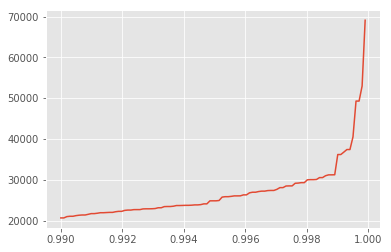

In [5]:
plt.plot(var_emp.keys(),var_emp.values())

### VaR estimation from EWMA

In [6]:
lam = 0.97
miu0 = df['logret'][:500].mean()
sig0 = df['logret'][:500].std()
miu0, sig0**2

(1.3403220000000082e-05, 6.080603847604169e-05)

In [7]:
sig = sig0
miu = miu0
xt = df["logret"][500:].values
for i in range(0, len(xt)):
    sig = np.sqrt(lam*sig**2 + (1-lam)*(xt[i]-miu)**2)
    miu = lam*miu + (1-lam)*xt[i]

In [8]:
var_ewma = {}
for alpha in np.arange(0.99, 0.999900001, 0.000099):
    var_ewma[alpha] = norm.ppf(alpha, -miu, sig)*1000000

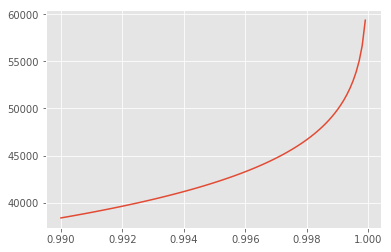

In [9]:
plt.plot(var_ewma.keys(),var_ewma.values())

### VaR estimation from GEV

In [10]:
n = 125
m = 55
maxt = [np.max(df['lin_loss'][n*i:n*(i+1)]) for i in range(0, m)]

In [11]:
ksai_gev, miu_gev, sig_gev = gev.fit(maxt)
ksai_gev, miu_gev, sig_gev

(-0.19946057228838981, 17325.273847282042, 6546.047743768569)

In [12]:
var_gev = {}
for alpha in np.arange(0.99, 0.999900001, 0.000099):
    var_gev[alpha] = miu_gev + sig_gev/ksai_gev*(1-(-n*np.log(alpha))**ksai_gev)

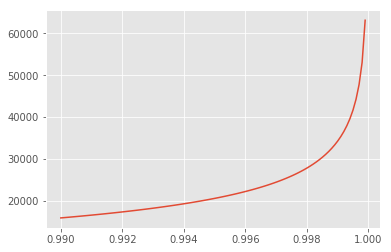

In [13]:
plt.plot(var_gev.keys(),var_gev.values())

### VaR estimation from GP

In [14]:
u = df['lin_loss'].quantile(0.95, interpolation="higher")

In [15]:
df['exc_loss'] = df['lin_loss']-u
exc_loss = np.array(df['exc_loss'])
pos_exc_loss = exc_loss[exc_loss>0]

In [16]:
ksai_gp, miu_gp, sig_gp = gp.fit(pos_exc_loss,floc=0)
ksai_gp, miu_gp, sig_gp

D:\Anaconda\lib\site-packages\scipy\stats\_continuous_distns.py:2248: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
D:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1035: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
D:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(0.12039581311975552, 0, 4498.321433726959)

In [17]:
var_gp = {}
for alpha in np.arange(0.99, 0.999900001, 0.000099):
    var_gp[alpha] = u + sig_gp/ksai_gp*((0.05/(1-alpha))**ksai_gp-1)

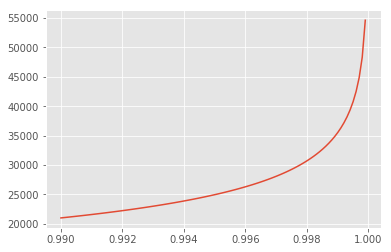

In [18]:
plt.plot(var_gp.keys(),var_gp.values())

### Plot all four estimation in one graph

In [19]:
df_var = pd.DataFrame([var_emp.values(), var_ewma.values(), var_gev.values(), var_gp.values()], columns=var_emp.keys(),
                      index=['Empirical', 'EWMA', 'GEV', 'GP']).T

In [20]:
df_var.head()

,Empirical,EWMA,GEV,GP
0.990000,20646.678,38389.224919,15865.174498,21005.162986
0.990099,20646.678,38445.406368,15927.780342,21059.520246
0.990198,20965.795,38502.080477,15991.139041,21114.489901
0.990297,21050.098,38559.256779,16055.267418,21170.085141
0.990396,21050.098,38616.945093,16120.182847,21226.319577


Text(0.5,1,'VaR Estimation')

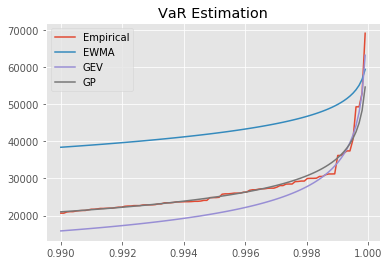

In [21]:
df_var.plot()
plt.title('VaR Estimation')

**Remark: The GP distribution approximates VaR best. EWMA behaves worst.**